### Enviroment prepare (imports)

In [103]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import  DataLoader,SubsetRandomSampler,ConcatDataset,Subset
from sklearn.model_selection import KFold
import pandas as pd

## DATA PREPARE

### IMPORT DATA

#### Datasets

Para abordagem de será feito uma validação cruzada apenas para a validação do treinamento da **epoch**, onde usaremos dois datasets:

- Fer Affectnet Database: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data?select=contempt
- Corrective re-annotation of FER - CK+ - KDEF: https://www.kaggle.com/datasets/sudarshanvaidya/corrective-reannotation-of-fer-ck-kdef?select=fer_ckplus_kdef
- Dataset montado a partir de outros datasets:
    1. FER Dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge
    2. CK Plus Dataset: https://github.com/WuJie1010/Facial-Expression-Recognition.Pytorch/tree/master/CK%2B48
    3. KDEF Dataset: https://www.kdef.se/download-2/register.html

Esses datasets possuem uma oitava classificação de expressão facial, na qual não usaremos em nosso desenvolvimento e aplicação, que é o **contempt**.

##### Dataset dispositions

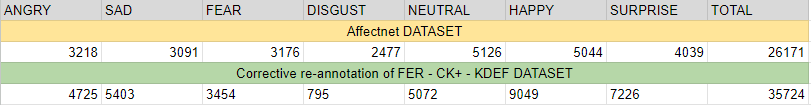

#### Transformation functions and hyperparams

Aqui optaremos por duas transformações de imagens de treinamento, em modelos como AlexNet, VGG que trabalham com imagens de escala maior usaremos *227x227 pixels* para treinamento do AlexNet e *224x224 pixels* para o VGG.

Outra abordagem será utilizar imagens de menor escala, para um rede neural menor de desenvolvimento próprio, baseado em outros notebooks e estudos relacionados, para esse modelo será utilizado amostras de imagens com a escala de *64x64 pixels*.

In [104]:
batch_size = 10
classes = ('angry', 'fear', 'happy', 'neutral', 'sad', 'surprise','disgust')

train_transform = transforms.Compose([
    # transforms.Resize((64,64)),
    # transforms.Resize((224,224)),
    transforms.Resize((227,227)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [105]:
train_dataset = datasets.ImageFolder('./color_dataset_2/train', transform=train_transform)
# train_loaded = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = datasets.ImageFolder('./fer_ckplus_dataset', transform=train_transform)
concat_data = ConcatDataset([train_dataset,validation_dataset])

## Cross-Validation 

###### We'll use the cross validation with a diferent dataset, to improve the cnn knowledge

In [106]:
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

## Define Models Architecture

#### AlexNet model to 64x64px

In [107]:
class FacialExpressionAlexNet(nn.Module):
    def __init__(self, num_classes=7):
        super(FacialExpressionAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [108]:
class AlexNet(nn.Module):
    #acuracia no teste=62.52% || 63.08%
    #acuracia no treino=81.46% || 86.80%
    def __init__(self,num_classes=7):
        super(AlexNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=10, stride=4, padding=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.pool1= nn.MaxPool2d(3,2)

        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(3,2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)

        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(384)

        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(3,2)

        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)


    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))   
        output = self.pool1(output)     
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool2(output)    

        output = F.relu(self.bn3(self.conv3(output)))     
        output = F.relu(self.bn4(self.conv4(output)))   
        output = F.relu(self.bn5(self.conv5(output))) 
        output = self.pool3(output)   

        output = output.reshape(output.size(0),-1)

        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)

        return output

In [109]:
class VGG19(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Model Definition

In [110]:
model = AlexNet()

### Define loss function and optimizer

In [111]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Runing on: "+ ("cuda" if torch.cuda.is_available() else "cpu"))

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate,  weight_decay = 0.001)

Runing on: cuda


### Model save

In [112]:
def saveModel():
    torch.save(model.state_dict(), "apurated_model_alex.pth")

## Training and Validation functions

In [113]:
def train_epoch(model,device,dataloader):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:

            images,labels = images.to(device),labels.to(device)
            output = model(images)
            loss=loss_fn(output,labels)
            valid_loss+=loss.item()*images.size(0)
            scores, predictions = torch.max(output.data,1)
            val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [114]:
def train(num_epochs):
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
    best_accuracy = 0.0

    model.to(device)
    
    for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(concat_data)))):

        print('Fold {}'.format(fold + 1))

        test_sampler = SubsetRandomSampler(val_idx)
        train_samples =  SubsetRandomSampler(train_idx)

        test_loader = DataLoader(concat_data, batch_size=batch_size, sampler=test_sampler)
        train_loader = DataLoader(concat_data, batch_size=batch_size, sampler=train_samples)

        for epoch in range(num_epochs):
            train_loss, train_correct=train_epoch(model,device,train_loader)
            test_loss, test_correct=valid_epoch(model,device,test_loader)

            train_loss = train_loss / len(train_loader.sampler)
            train_acc = train_correct / len(train_loader.sampler) * 100

            test_loss = test_loss / len(test_loader.sampler)
            test_acc = test_correct / len(test_loader.sampler) * 100

            print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                                    num_epochs,
                                                                                                                    train_loss,
                                                                                                                    test_loss,
                                                                                                                    train_acc,
                                                                                                                    test_acc))
            if train_acc > best_accuracy:
                saveModel()
                best_accuracy = train_acc
                print("Best Accuracy:{} %".format(best_accuracy))

            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['train_acc'].append(train_acc)
            history['test_acc'].append(test_acc)   

    df_history = pd.DataFrame(data=history)
    df_history.to_csv("historic_alex.csv", encoding='utf-8', index=False)

## Training

In [115]:
torch.cuda.empty_cache()

torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 478346 KiB |   2039 MiB | 269051 GiB | 269050 GiB |\n|       from large pool | 477783 KiB |   2037 MiB | 268271 GiB | 268270 GiB |\n|       from small pool |    563 KiB |      8 MiB |    780 GiB |    780 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 478346 KiB |   2039 MiB | 269051 GiB | 269050 GiB |\n|       from large pool | 477783 KiB |   2037 MiB |

In [116]:
train(20)
print('Finished Training')

Fold 1
Epoch:1/20 AVG Training Loss:1.704 AVG Test Loss:1.326 AVG Training Acc 32.15 % AVG Test Acc 48.02 %
Best Accuracy:32.14722052535125 %
Epoch:2/20 AVG Training Loss:1.216 AVG Test Loss:1.213 AVG Training Acc 52.15 % AVG Test Acc 52.95 %
Best Accuracy:52.15142028100183 %
Epoch:3/20 AVG Training Loss:1.124 AVG Test Loss:1.121 AVG Training Acc 55.83 % AVG Test Acc 56.61 %
Best Accuracy:55.83384239462431 %
Epoch:4/20 AVG Training Loss:1.065 AVG Test Loss:1.060 AVG Training Acc 58.89 % AVG Test Acc 59.03 %
Best Accuracy:58.893937080024436 %
Epoch:5/20 AVG Training Loss:1.035 AVG Test Loss:1.018 AVG Training Acc 60.28 % AVG Test Acc 61.02 %
Best Accuracy:60.27985644471594 %
Epoch:6/20 AVG Training Loss:1.011 AVG Test Loss:0.996 AVG Training Acc 61.25 % AVG Test Acc 61.71 %
Best Accuracy:61.25152718387293 %
Epoch:7/20 AVG Training Loss:0.996 AVG Test Loss:1.028 AVG Training Acc 62.09 % AVG Test Acc 60.20 %
Best Accuracy:62.09338729383018 %
Epoch:8/20 AVG Training Loss:0.985 AVG Test Los

# TEST

In [122]:
test_transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder('./color_dataset_2/test', transform=test_transform)
test_loaded = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [123]:
def test_model(model):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loaded:

            output = model(images)
            loss=loss_fn(output,labels)
            valid_loss+=loss.item()*images.size(0)
            scores, predictions = torch.max(output.data,1)
            val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [124]:
def testBatch(model):
    model.eval()
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loaded))
   
    # show all images as one image grid
    img = torchvision.utils.make_grid(images)     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    with torch.no_grad():
        output = model(images)
        scores, predictions = torch.max(output.data,1)
        
        # Let's show the predicted labels on the screen to compare with the real ones
        print('Predicted: ', ' '.join('%5s' % classes[predictions[j]] 
                                for j in range(batch_size)))

In [125]:
model = AlexNet()
path = "apurated_model_alex.pth"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [126]:
valid_loss,val_correct = test_model(model)

valid_loss = valid_loss / len(test_loaded.sampler)
val_acc = val_correct / len(test_loaded.sampler) * 100

print("AVG Test Loss:{:.3f} AVG Test Acc {:.2f} %".format(valid_loss,val_acc))
                                    

AVG Test Loss:1.431 AVG Test Acc 57.25 %
